In [13]:
from helper_functions import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.interpolate as interp
import scipy as sp
import re
import tensorflow as tf
import tensorflow.keras as keras

In [21]:
#create dataset
data = []
truth = []

#Each loop picks a skewer, and labels the galaxies near to it. 
#There is double counting probably if skewers pass near each other, but this is fine
#A galaxy can impact more than one LOS
LOS_num = 20
#parameters for binning. Adjust this to get finer and wider bins
distance_along_LOS_bins = 100
mass_bins = 10
radial_bins = 10

for i in np.arange(1,LOS_num+1):
    #see how far along this part is
    print(i)
    #pulling data from galaxies
    flux_path = '/data/gnedin/REI/D/Cai.B40.N256L2.sf=1_uv=0.15_bw=10_res=100.WC1/A/a=0.1452/los/los.00' + '{0:03}'.format(i) +'.raw'

    temp = get_galaxies("/data/gnedin/REI/D/Cai.B40.N256L2.sf=1_uv=0.15_bw=10_res=100.WC1/A/a=0.1452/hprops.res", flux_path, i)
    
    #setting up the bins in which we will categorize our galaxies
    temp = np.swapaxes(temp, 0, 1)[:, 0:3]
    #mass
    bin1 = np.logspace(min(temp[:,0]), max(temp[:,0]), mass_bins+1)
    #along LOS
    bin2 = np.linspace(5,95, distance_along_LOS_bins+1)
    #radial distance
    bin3 = np.linspace(min(temp[:,2]), max(temp[:,2]), radial_bins+1)
    H, edges = np.histogramdd(temp, bins=(bin1, bin2, bin3))
    
    #pulling truth (what we are trying to predict) from the flux
    flux_path = '/data/gnedin/REI/D/Cai.B40.N256L2.sf=1_uv=0.15_bw=10_res=100.WC1/A/a=0.1452/los/los.00' + '{0:03}'.format(i) +'.fHI'

    #converting to distance from velocity.
    velocity, flux = unPackRawFlux(flux_path)
    flux_distance = hubble_flow_convert(velocity, a=0.1452, omega_m=0.3036, omega_lam=0.6964)
    
    #they are slightly different lengths so we chop off the ends. Because of peculiar velocity we will lose some info
    new_flux_distance = np.linspace(5,95, 16000)
    new_flux = resample(flux_distance, flux, new_flux_distance)
    
    flux_temp = new_flux.reshape(int(new_flux.shape[0]/160), 160).mean(axis=1)
    
    if len(data)==0:
        data = np.array([H])
        truth = np.array([flux_temp])
    else:
        data = np.append(data, [H], axis=0)
        truth = np.append(truth, [flux_temp], axis=0)

data = data.reshape(LOS_num-1, 10, 100, 10, 1)
#correction for the future (probably could write this better later to be honest)
data = np.swapaxes(data, 2, 3)

#Now we have a data array, and truth array to test it against

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


ValueError: cannot reshape array of size 200000 into shape (19,10,100,10,1)

In [20]:
#check shapes
print(truth.shape)
print(data.shape)

(19, 100)
(19, 10, 10, 100, 1)


In [14]:
tf.compat.v1.reset_default_graph()

def build_and_compile_model():
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(10, 10, distance_along_LOS_bins, 1)),
        keras.layers.Conv3D(filters=1, kernel_size=(mass_bins, 1, 1)),
        keras.layers.Conv3D(filters=1, kernel_size=(1, radial_bins, 1)),
        keras.layers.Flatten(),
        keras.layers.Dense(100),

    ])
    
    model.compile(loss='mean_squared_error',
                optimizer=keras.optimizers.Adam(0.0005))
    
    return model

In [15]:
#build NN and check that it worked, and all dimensions are right
galaxies_spikes = build_and_compile_model()
galaxies_spikes.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 1, 10, 100, 1)     11        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 1, 100, 1)      11        
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
Total params: 10,122
Trainable params: 10,122
Non-trainable params: 0
_________________________________________________________________


In [16]:
#train
history = galaxies_spikes.fit(data, truth, epochs=100)

Train on 1 samples
Epoch 1/100
1/1 [==============================] - 0s 365ms/sample - loss: 0.0017
Epoch 2/100
1/1 [==============================] - 0s 5ms/sample - loss: 0.0017
Epoch 3/100
1/1 [==============================] - 0s 4ms/sample - loss: 0.0016
Epoch 4/100
1/1 [==============================] - 0s 4ms/sample - loss: 0.0016
Epoch 5/100
1/1 [==============================] - 0s 4ms/sample - loss: 0.0016
Epoch 6/100
1/1 [==============================] - 0s 4ms/sample - loss: 0.0016
Epoch 7/100
1/1 [==============================] - 0s 3ms/sample - loss: 0.0016
Epoch 8/100
1/1 [==============================] - 0s 3ms/sample - loss: 0.0015
Epoch 9/100
1/1 [==============================] - 0s 3ms/sample - loss: 0.0015
Epoch 10/100
1/1 [==============================] - 0s 3ms/sample - loss: 0.0015
Epoch 11/100
1/1 [==============================] - 0s 3ms/sample - loss: 0.0015
Epoch 12/100
1/1 [==============================] - 0s 3ms/sample - loss: 0.0014
Epoch 13/100
1/1

Epoch 99/100
1/1 [==============================] - 0s 2ms/sample - loss: 6.6676e-07
Epoch 100/100
1/1 [==============================] - 0s 2ms/sample - loss: 6.4703e-07


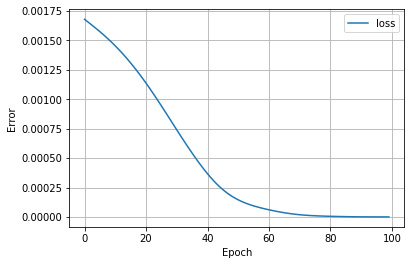

In [17]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
plot_loss(history)

(1, 100)


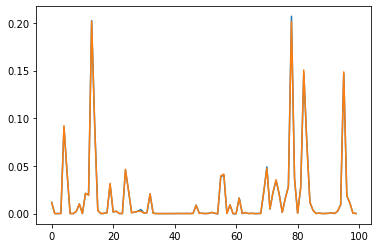

In [18]:
#see if the predictions are actually working. Note, we didn't set aside test data yet.
#I haven't gotten anything to work, so I'm skipping that for now
pred = galaxies_spikes.predict(data)
print(pred.shape)
plt.plot(pred[0,:]*1)
plt.plot(truth[0,:])
plt.show()